# Deep learning

Deep Learning is a Machine Learning technique that uses neural network model to learn. If there is enough data, those model can be more performant than normal machine learning model.

Deep Learning usualy has the usual goal of making  machine learning models learn how to do  feature extraction




# Base setup

In [2]:
% matplotlib inline
import pandas as pd
import itertools as itt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import * 


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_percentage_error(y_true, y_pred):
    return np.mean(( (y_true - y_pred) / y_true)**2) * 100

#Tensorboard visualiser
#small Hack to see tensorboard in jupyter notebook
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Getting data

In [14]:
dataf = pd.read_csv("../data/featured_proto_traffic.csv")
del dataf['timestamp']
data = dataf.values

n = data.shape[0]
p = data.shape[1]

# Transforming data


In [15]:
from sklearn.preprocessing import MinMaxScaler

train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]




In [16]:
tf.reset_default_graph()


sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Model architecture parameters
n_data = 57
n_neurons_1 = 30
n_neurons_2 = 15
n_neurons_3 = 6
n_neurons_4 = 2
n_target = 1
# Layer 1: Variables for hidden weights and biases



with tf.name_scope("W"):
    W_hidden_1 = tf.Variable(weight_initializer([n_data, n_neurons_1]),name="1") 
    W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]),name="2")
    W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]),name="3")
    W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]),name="4")


with tf.name_scope('bias') as scope: 
    bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]),name="1") 
    bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]),name="2")
    bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]),name="3")
    bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]),name="3")

    
bias_out = tf.Variable(bias_initializer([n_target]),name="bias_out")
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]),name="W_out")
    
X = tf.placeholder(dtype=tf.float32, shape=[None, n_data],name="PlaceholderX")
Y = tf.placeholder(dtype=tf.float32, shape=[None],name="PlaceholderY")

    
with tf.name_scope('hiddenLayer') as scope:
    # Hidden layer
    hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
    hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
    hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
    hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))


with tf.name_scope("output_transform") as scope:
    adder = tf.add(tf.matmul(hidden_4, W_out), bias_out)    

out = tf.transpose(adder,name="output")
mse = tf.reduce_mean(tf.squared_difference(out, Y),name="mse_training")
opt = tf.train.AdamOptimizer(learning_rate=0.000130,).minimize(mse)

In [17]:
show_graph(tf.get_default_graph().as_graph_def())

# Modeling

we model with a reasonable number of epoch

most of parameters was found with trial and error, 
a better method would be to gridsearch... etc.

In [18]:
#methods for visualisation 

def plotPredictionResult(prediction,y,title):
    with plt.style.context('seaborn-white'):   
        plt.figure(figsize=(15, 3))
        plt.plot(y, label="actual", linewidth=2.0)
        plt.plot(prediction, label="prediction", linewidth=2.0)
        plt.title(title)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True);
        
def showModelStats(model):
    pred_test = model.run(out, feed_dict={X: X_test})[0]
    pred_train = model.run(out, feed_dict={X: X_train})[0]

    def print_error(pred,real,name):
        print(f"{name}-r2:",r2_score(pred,real))
        print(f"{name}-MAPE:",100 - mean_absolute_percentage_error(pred,real),"%")
        print(f"{name}-MSPE:",100 - mean_squared_percentage_error(pred,real),"%")
        print("="*10)
    
    print_error(pred_train,y_train,"Train")
    plotPredictionResult(pred_train,y_train,title="Train Result")
    
    print_error(pred_test,y_test,"Test")
    plotPredictionResult(pred_test,y_test,title="Test Result")
   
    begin,end = -144*3,-144
    zoom_pred,zoom_test = pred_test[begin:end],y_test[begin:end]
    print_error(zoom_pred,zoom_test,"Test")
    plotPredictionResult(zoom_pred,zoom_test,title="Zoomed Result")


te_mae 24.180972568771992
tr_mae 26.09630594335402
epoch done :: 0
te_mae 22.718317898193973
tr_mae 25.447689262308398
epoch done :: 1
te_mae 22.214272337447984
tr_mae 24.875924897230046
epoch done :: 2
te_mae 21.956823203401672
tr_mae 24.568577599037454
epoch done :: 3
te_mae 21.849426376669197
tr_mae 24.311905216608213
epoch done :: 4
te_mae 21.81086909854616
tr_mae 24.411948883688133
epoch done :: 5
te_mae 21.722538492885107
tr_mae 24.200723082660442
epoch done :: 6
te_mae 21.678968592470948
tr_mae 24.205170828299458
epoch done :: 7
te_mae 21.758651650889064
tr_mae 24.00448878109736
epoch done :: 8
te_mae 21.685149784515538
tr_mae 24.075338129996755
epoch done :: 9
te_mae 21.63063709854209
tr_mae 23.872160052337296
epoch done :: 10
te_mae 21.54857297673318
tr_mae 24.000818384419535
epoch done :: 11
te_mae 21.515427659659807
tr_mae 23.68941355870425
epoch done :: 12
te_mae 21.700087081067533
tr_mae 23.621155769931327
epoch done :: 13
te_mae 21.393603521230045
tr_mae 23.77791779611383

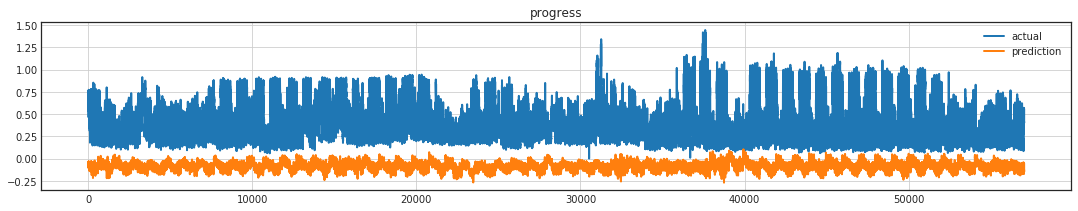

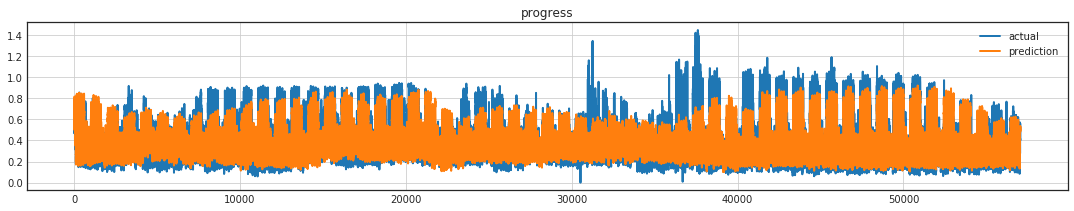

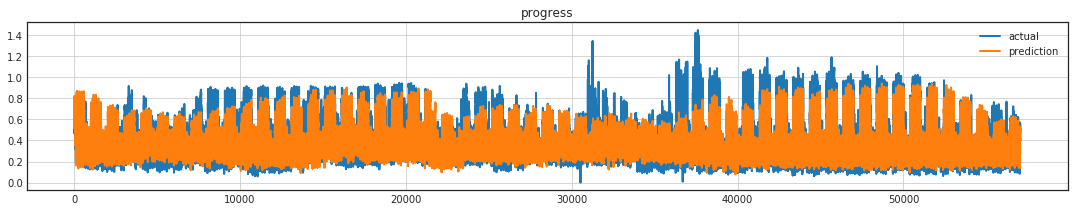

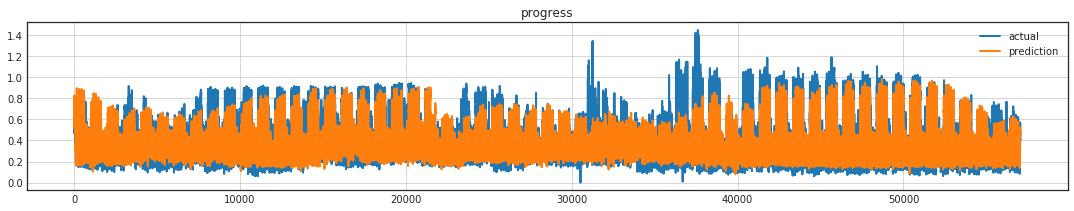

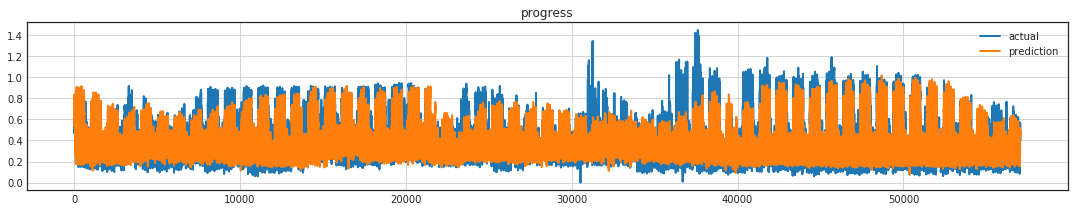

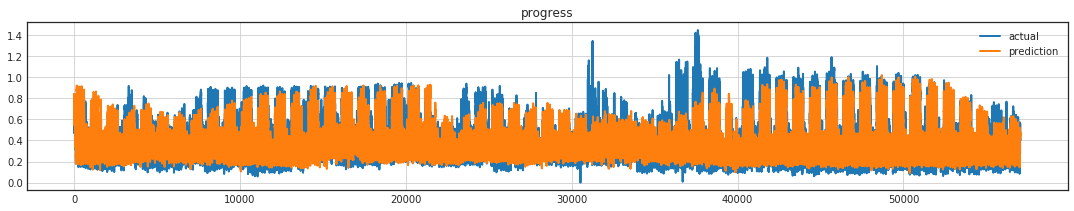

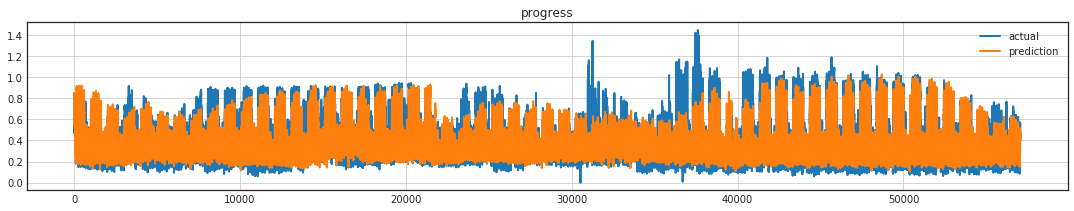

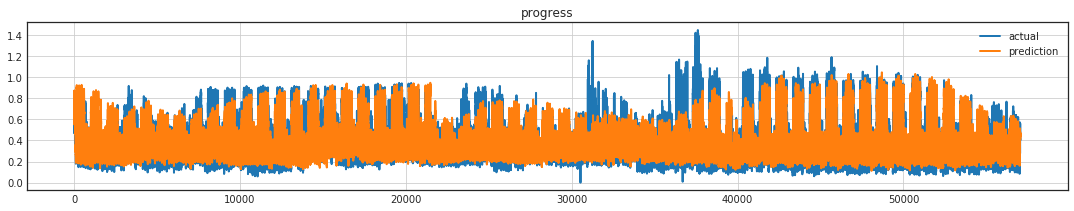

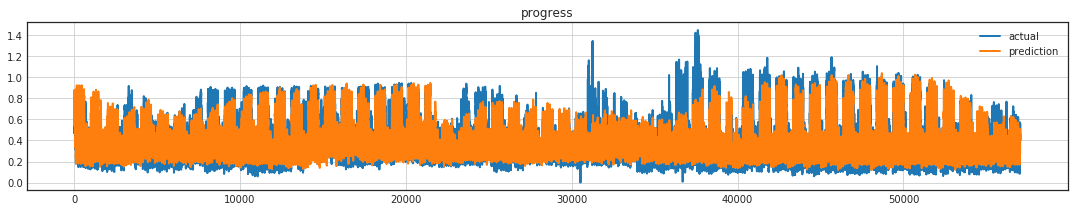

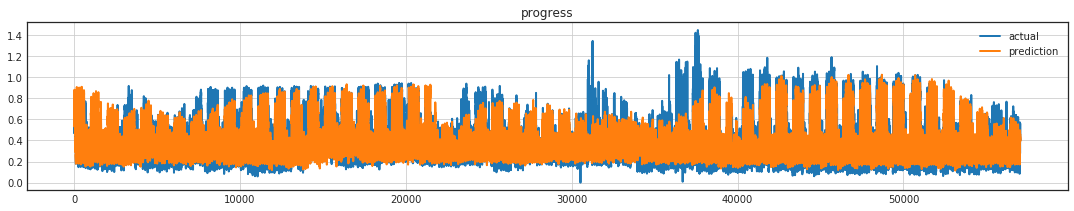

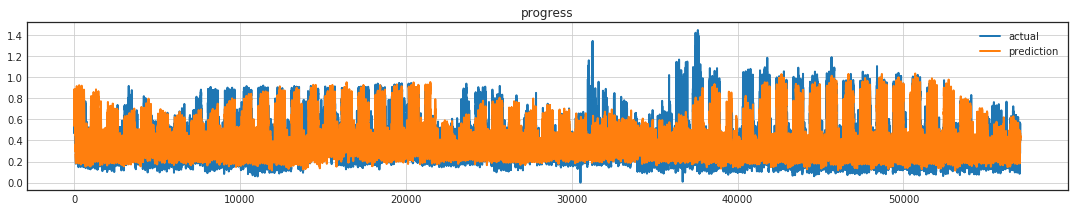

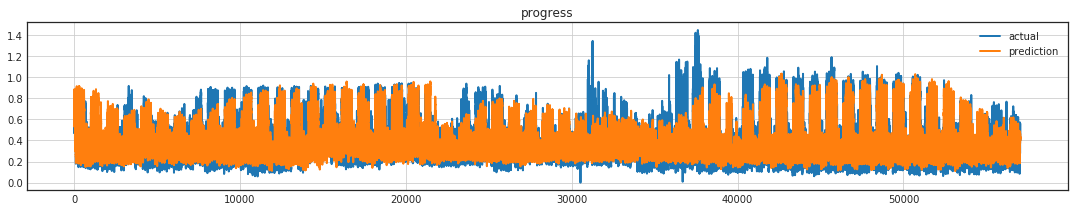

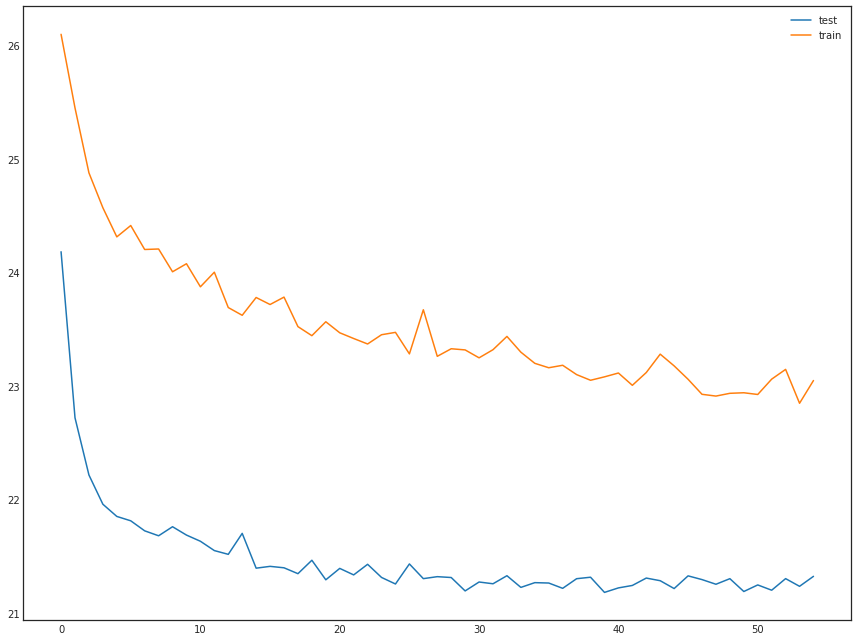

In [19]:
%%time
# Make Session
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())


# Number of epochs and batch size
epochs = 55
batch_size = 256

epoch_test_accuracy = []
shuffle_X = X_train.copy()
shuffle_Y = y_train.copy()



test_errs,train_errs = [],[]
for e in range(epochs):
    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    shuffle_X = shuffle_X[shuffle_indices]
    shuffle_Y = shuffle_Y[shuffle_indices]
    
    #run prediction
    if not e % 5:
        plotPredictionResult(net.run(out, feed_dict={X: X_test})[0],y_test,"progress")

    
    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = shuffle_X[start:start + batch_size]
        batch_y = shuffle_Y[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
    
    te_mae = mean_absolute_percentage_error(net.run(out, feed_dict={X: X_test}),y_test)
    tr_mae = mean_absolute_percentage_error(net.run(out, feed_dict={X: X_train}),y_train)
    test_errs.append(te_mae),train_errs.append(tr_mae)
    print("te_mae", te_mae),print("tr_mae",tr_mae)
    print("epoch done ::", e)
    print("=" * 10)
    

    

#run prediction
plotPredictionResult(net.run(out, feed_dict={X: X_test})[0],y_test,"progress")
    
with plt.style.context('seaborn-white'):   
    plt.figure(figsize=(12,9))
    plt.plot(test_errs,label="test")
    plt.plot(train_errs,label="train")  
    plt.legend(loc="best")
    plt.tight_layout()


# Observations

Train-r2: 0.6008836053137433
Train-MAPE: 76.95339405886466 %
Train-MSPE: 88.1993692553708 %
Test-r2: 0.5367495168792933
Test-MAPE: 78.67833018547816 %
Test-MSPE: 89.99949578309248 %
Test-r2: 0.6724014360271184
Test-MAPE: 84.53015942380104 %
Test-MSPE: 96.13557803712825 %


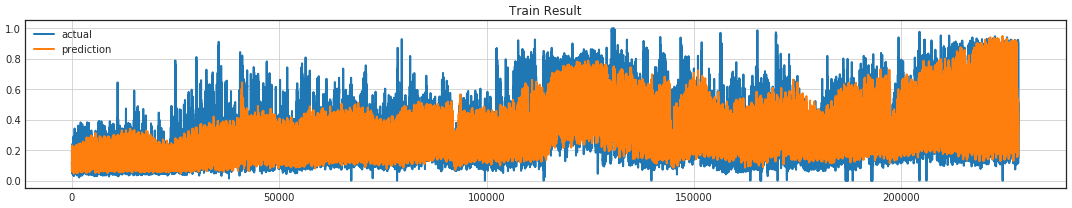

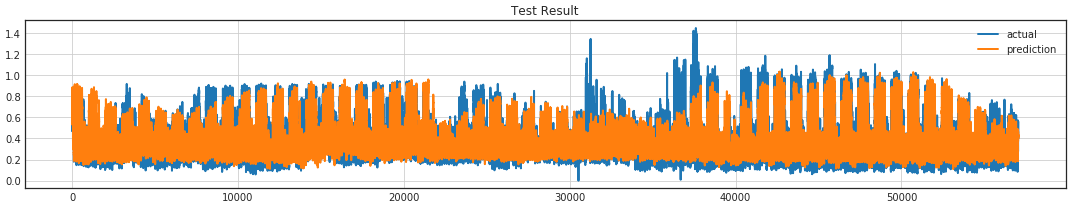

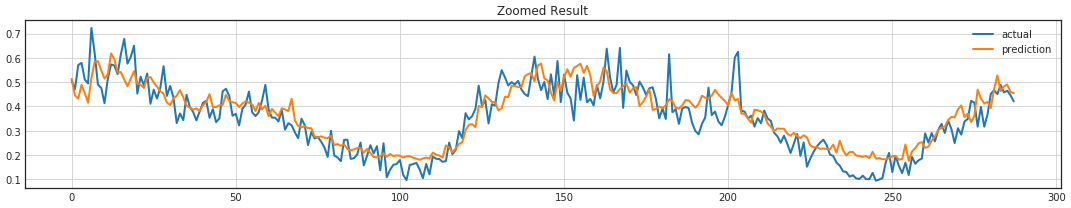

In [20]:
showModelStats(net)